In [1]:
import pyemu
import flopy as fp
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

flopy is installed in C:\Users\schorppl\AppData\Local\Continuum\anaconda3\lib\site-packages\flopy


In [2]:
t_d ="template"
case = "2D_test"
pst = pyemu.Pst(os.path.join(t_d,"{}.pst".format(case)))
pst.write_par_summary_table(filename="none")

,type,transform,count,initial value,upper bound,lower bound,standard deviation
kp_inst:0,kp_inst:0,log,95,0,2,-2,1


[<Figure size 576x756 with 0 Axes>, <Figure size 576x756 with 8 Axes>]

<Figure size 576x756 with 0 Axes>

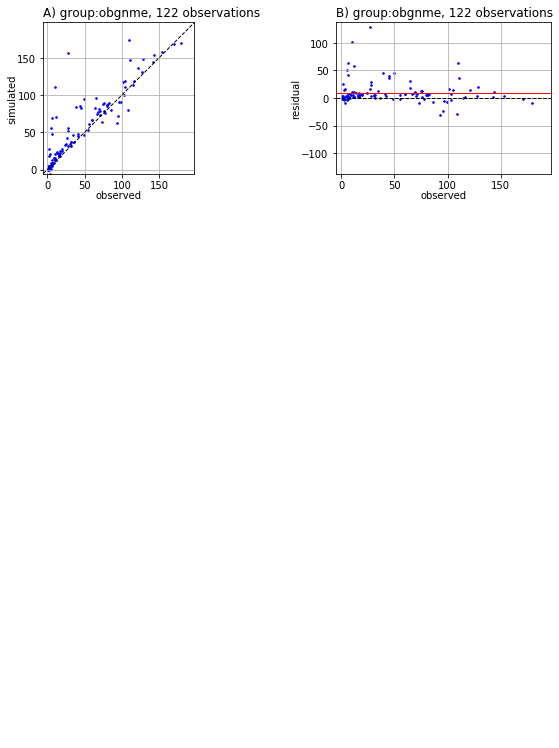

In [3]:
pst.plot(kind='1to1')

In [4]:
pst.control_data.noptmax = 6 # number of iterations (should be set to a great value (50))
pst.pestpp_options["n_iter_base"] = -1
pst.pestpp_options["n_iter_super"] = 3
pst.pestpp_options["glm_num_reals"] = 50 # how many draws
pst.pestpp_options["parcov"] = "{}.prior.cov".format(case)
pst.pestpp_options["base_jacobian"] = "{}.jcb".format(case)
pst.write(os.path.join(t_d,"{}.pst".format(case)))

noptmax:6, npar_adj:95, nnz_obs:122


In [11]:
# DO the inversion
m_d = "master_glm_run"
pyemu.os_utils.start_workers(t_d,"../../pestpp-glm.exe","{}.pst".format(case),num_workers=5,worker_root=".",
                             master_dir=m_d)

[<Figure size 576x756 with 0 Axes>, <Figure size 576x756 with 8 Axes>]

<Figure size 576x756 with 0 Axes>

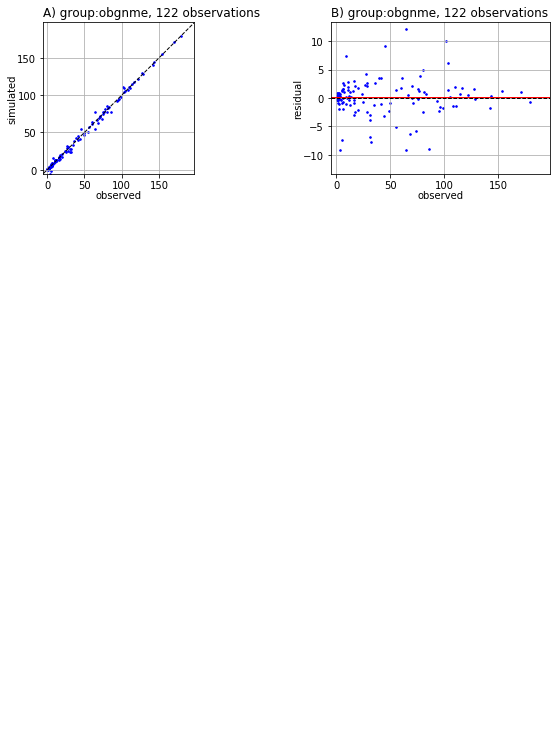

In [13]:
pst_2 = pyemu.Pst(os.path.join(m_d,"{}.pst".format(case)))
pst_2.plot(kind="1to1")

1253.0720266209105 {'obgnme': 1253.0720266209105} {'obgnme': 1.0}


[None,
 None,

<Figure size 576x756 with 0 Axes>

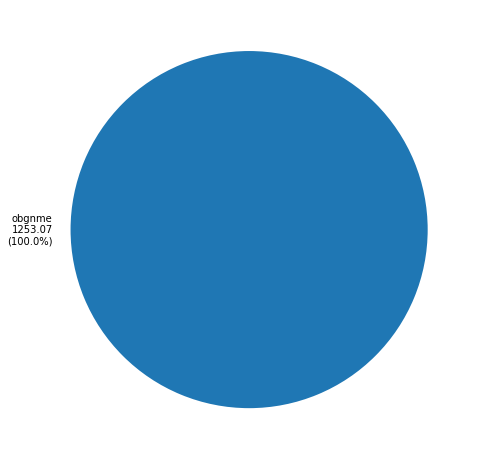

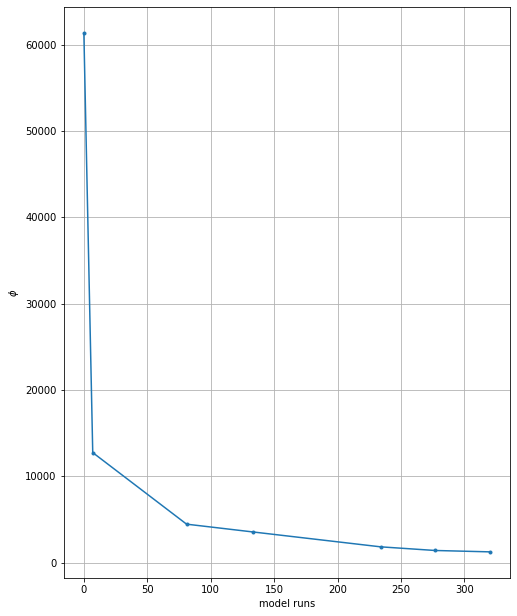

In [14]:
pst_2.plot()

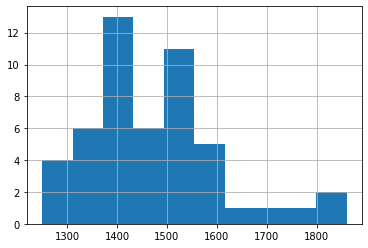

In [16]:
df = df=pd.read_csv(os.path.join(m_d,"{}.post.obsen.csv".format(case)),index_col=0)
oe = pyemu.ObservationEnsemble.from_dataframe(pst=pst,df=df)

ax = oe.phi_vector.hist()

In [21]:
dfp = df=pd.read_csv(os.path.join(m_d,"{}.par.usum.csv".format(case)),index_col=0)
dfp["post_mean"]

name
KP_INST:0_I:15_J:125    -0.178365
KP_INST:0_I:35_J:125    -2.000000
KP_INST:0_I:45_J:105    -2.000000
KP_INST:0_I:45_J:115     2.000000
KP_INST:0_I:45_J:125    -2.000000
                           ...   
KP_INST:0_I:155_J:115   -0.543282
KP_INST:0_I:155_J:125   -0.906765
KP_INST:0_I:165_J:55     2.000000
KP_INST:0_I:165_J:65    -2.000000
KP_INST:0_I:165_J:95    -2.000000
Name: post_mean, Length: 95, dtype: float64

In [23]:
pst_2.parameter_data.parval1 = 10**dfp["post_mean"].values
pst_2.control_data.noptmax = 0 # one run

pst_2.write(os.path.join(t_d,"{}.pst".format(case)))
pyemu.os_utils.run("..\..\pestpp-glm.exe {}".format(case),cwd="template")

noptmax:0, npar_adj:95, nnz_obs:122


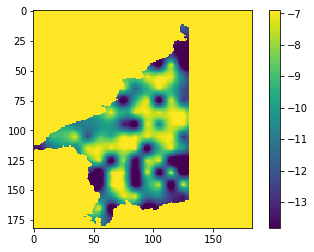

In [24]:
# inversion
plt.imshow(np.log(np.loadtxt(os.path.join(t_d,"k.txt"))))
plt.colorbar()

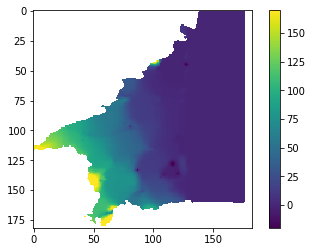

In [35]:
import sys
sys.path.append("../../modules")
# hand made functions
from Rouss import *

head = get_heads("pest_2D_R","template")
head[head>1000] = None
plt.imshow(head[0],vmin=-20,vmax=170)
plt.colorbar()